<h3> week 9.1 GreatOutdoors inlezen

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pyodbc
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


<h3> verbinding maken database

In [19]:

# Verbindingsgegevens
server = '127.0.0.1'        
port = '1433'               
database = 'DataWarehouse'         
username = 'SA'             
password = 'iDTyjZx7dRL4'  

# Connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server},{port};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    "TrustServerCertificate=yes;"
    "Timeout=30;"
)

# Maak verbinding met de database
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()



<H3> Inlezen benodigde tabellen

In [20]:
df_sales = pd.read_sql("SELECT * FROM Fact_Sales", conn)
df_product = pd.read_sql("SELECT * FROM Dim_Product", conn)
df_time = pd.read_sql("SELECT * FROM Dim_Time", conn)
df_retailer = pd.read_sql("SELECT * FROM Dim_Retailer", conn)
df_sales_team = pd.read_sql("SELECT * FROM Dim_Sales_Team", conn)
df_order_method = pd.read_sql("SELECT * FROM Dim_Order_Method", conn)


/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2655038888.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales = pd.read_sql("SELECT * FROM Fact_Sales", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2655038888.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product = pd.read_sql("SELECT * FROM Dim_Product", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2655038888.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_time = pd.read_sql("SELECT *

<h3> mergen dfs

In [21]:
df = df_sales.merge(df_product, on='Product_Key', how='left') \
             .merge(df_time, on='Time_Key', how='left') \
             .merge(df_retailer, on='Retailer_Key', how='left') \
             .merge(df_sales_team, on='Sales_Team_Key', how='left') \
             .merge(df_order_method, on='Order_Method_Key', how='left')

# selecteer alleen relevante kolommen
df = df[[
    'Total_Sales', 'Production_Cost', 'Margin',
    'Product_Type_EN', 'Product_Line_EN',
    'Year', 'Month', 'Quarter',
    'Retailer_Type_EN', 'Segment_Name', 'Country_EN', 'Region',
    'Position_EN', 'Branch_City',
    'Order_Method_EN'
]]

print(df.columns.to_list())

['Total_Sales', 'Production_Cost', 'Margin', 'Product_Type_EN', 'Product_Line_EN', 'Year', 'Month', 'Quarter', 'Retailer_Type_EN', 'Segment_Name', 'Country_EN', 'Region', 'Position_EN', 'Branch_City', 'Order_Method_EN']


<h3> dummy encoding toepassen categorische kolommen

In [22]:
categoricals = ['Product_Type_EN', 'Product_Line_EN', 'Retailer_Type_EN',
                'Segment_Name', 'Country_EN', 'Region', 'Position_EN',
                'Branch_City', 'Order_Method_EN']

df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)



<h4> opdelen in features en target

In [23]:
X = df_encoded.drop('Total_Sales', axis=1)
y = df_encoded['Total_Sales']

# Controleer op volledig ontbrekende kolommen
print("Volledig ontbrekende kolommen:")
print(X.isnull().all())

# Verwijder volledig ontbrekende kolommen
X = X.loc[:, ~X.isnull().all()]

# Vul ontbrekende waarden in met het gemiddelde
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Imputatie voltooid!")

Volledig ontbrekende kolommen:
Production_Cost                False
Margin                         False
Year                            True
Month                           True
Quarter                         True
                               ...  
Order_Method_EN_Mail           False
Order_Method_EN_Sales visit    False
Order_Method_EN_Special        False
Order_Method_EN_Telephone      False
Order_Method_EN_Web            False
Length: 127, dtype: bool
Imputatie voltooid!


<h3> test het splitten

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#om ervoor te zorgen dat de randomness niet elke keer verandert als je hem opnieuwe runt zodat je dezelfde resultaten krijgt

<h3> resgressiemodel testen

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

<h3> Model Evalueren

In [26]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 37899504.13
R-squared (R²): 0.46


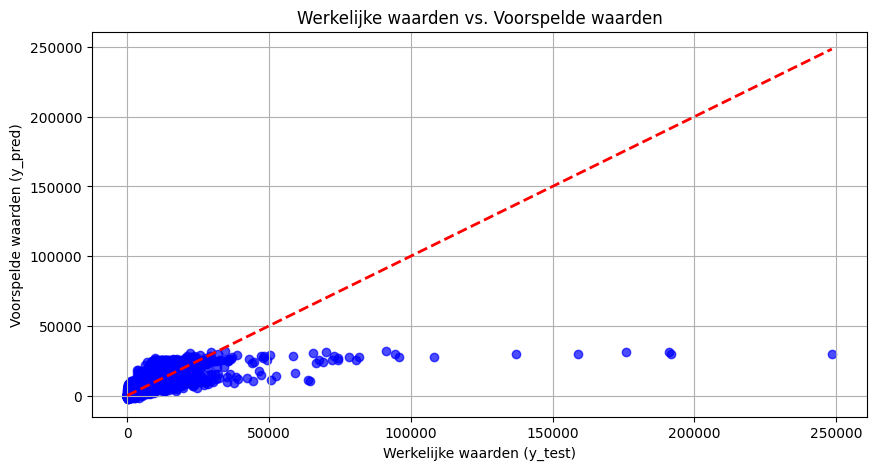

In [27]:

# Scatterplot: Werkelijke waarden vs. Voorspelde waarden
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonale lijn
plt.title('Werkelijke waarden vs. Voorspelde waarden')
plt.xlabel('Werkelijke waarden (y_test)')
plt.ylabel('Voorspelde waarden (y_pred)')
plt.grid(True)
plt.show()



<h3> ander model testen

In [28]:


# Train een Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Voorspel de testdata
y_pred = model.predict(X_test)

# Bereken MSE en R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 22807509.67
R-squared (R²): 0.67


<h3> visualisaties van andere model

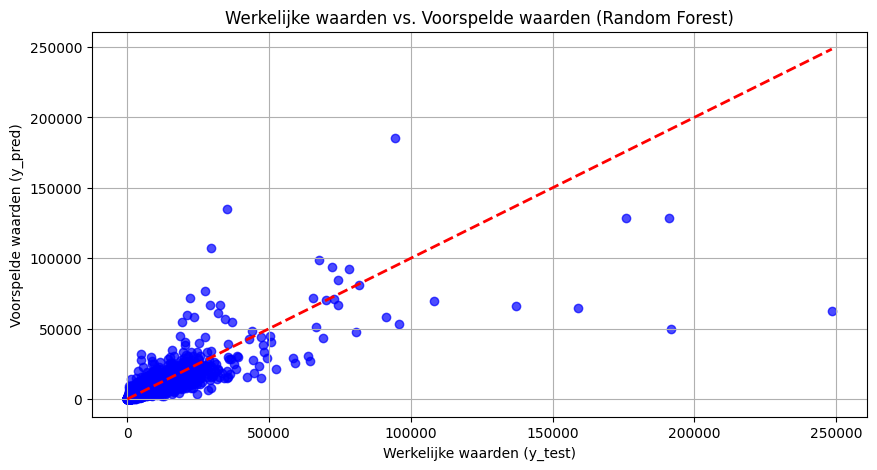

In [29]:
# Scatterplot: Werkelijke waarden vs. Voorspelde waarden
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonale lijn
plt.title('Werkelijke waarden vs. Voorspelde waarden (Random Forest)')
plt.xlabel('Werkelijke waarden (y_test)')
plt.ylabel('Voorspelde waarden (y_pred)')
plt.grid(True)
plt.show()



De resultaten laten zien dat het Random Forest-model duidelijke winst boekt ten opzichte van de lineaire regressie:

Lineair model: MSE = 37,9 mln, R² = 0.46 → verklaart 46 % van de variantie, vrij grove voorspellingen.
Random Forest: MSE = 22,8 mln, R² = 0.67 → verklaart 67 % van de variantie, met substantieel nauwkeurigere inschattingen.
Conclusie: het Random Forest-model presteert aanzienlijk beter (lagere fout, hogere R²) en is daarmee de voorkeur voor de sales‐voorspelling.

verbeterpunten voor in de toekomst:
- Analyseer en verwijder outliers.


<h3> Week 9.2 verbinden + inlezen SDM en mergen benodigde tabellen

In [30]:

# Verbindingsgegevens
server = '127.0.0.1'        
port = '1433'               
database = 'GreatOutdoorsSDM'         
username = 'SA'             
password = 'iDTyjZx7dRL4'  

# Connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server},{port};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    "TrustServerCertificate=yes;"
    "Timeout=30;"
)

# Maak verbinding met de database
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()


#inlezen benodigde tabellen
order_details = pd.read_sql("SELECT * FROM order_details", conn)
returned_item = pd.read_sql("SELECT * FROM returned_item", conn)
return_reason = pd.read_sql("SELECT * FROM return_reason", conn)
order_header = pd.read_sql("SELECT * FROM order_header", conn)
order_method = pd.read_sql("SELECT * FROM order_method", conn)

#retailer toevoegen en mergen (met elkaar laten pas met df)
retailer = pd.read_sql("SELECT * FROM retailer", conn)
retailer_headquarters = pd.read_sql("SELECT * FROM retailer_headquarters", conn)
retailer_segment = pd.read_sql("SELECT * FROM retailer_segment", conn)
retailer_type = pd.read_sql("SELECT * FROM retailer_type", conn)

retailer = retailer.merge(retailer_headquarters, on="RETAILER_CODEMR", how="left")
retailer = retailer.merge(retailer_segment, on="SEGMENT_CODE", how="left")
retailer = retailer.merge(retailer_type, on="RETAILER_TYPE_CODE", how="left")

retailer_site = pd.read_sql("SELECT * FROM retailer_site", conn)
retailer_site = retailer_site.merge(retailer, on="RETAILER_CODE", how="left")

#country en sales_territory toevoegen en mergen (met elkaar laten pas met df)
country = pd.read_sql("SELECT * FROM country", conn)
sales_territory = pd.read_sql("SELECT * FROM sales_territory", conn)

country = country.merge(sales_territory, on="SALES_TERRITORY_CODE", how="left")

#merge retuend_item met return_reason
returned = returned_item.merge(return_reason, on="RETURN_REASON_CODE", how="left")

#merge order_details met returned
df = order_details.merge(returned, on="ORDER_DETAIL_CODE", how="left")


#merge met order_header
df = df.merge(order_header, on="ORDER_NUMBER", how="left")

#merge met order_method
df = df.merge(order_method, on="ORDER_METHOD_CODE", how="left")

#merge met retailer_site
df = df.merge(retailer_site, on="RETAILER_SITE_CODE", how="left")


# Hernoem kolommen met suffixen (_x, _y) naar hun originele naam
df.columns = df.columns.str.replace('_x', '', regex=False)
df.columns = df.columns.str.replace('_y', '', regex=False)


# Verwijder dubbele kolommen en herstel de originele namen
df = df.loc[:, ~df.columns.duplicated()]  

# Controleer de kolomnamen na verwerking
print(df.columns.duplicated())

#merge met country
df = df.merge(country, on="COUNTRY_CODE", how="left")

#invullen alle NaN met 'n.v.t.'
df['RETURN_DESCRIPTION_EN'] = df['RETURN_DESCRIPTION_EN'].fillna('n.v.t.')

print (df.columns.to_list())   



[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
['ORDER_DETAIL_CODE', 'ORDER_NUMBER', 'PRODUCT_NUMBER', 'QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'RETURN_CODE', 'RETURN_DATE', 'RETURN_REASON_CODE', 'RETURN_QUANTITY', 'RETURN_DESCRIPTION_EN', 'RETAILER_NAME', 'RETAILER_SITE_CODE', 'RETAILER_CONTACT_CODE', 'SALES_STAFF_CODE', 'SALES_BRANCH_CODE', 'ORDER_DATE', 'ORDER_METHOD_CODE', 'ORDER_METHOD_EN', 'RETAILER_CODE', 'ADDRESS1', 'ADDRESS2', 'CITY', 'REGION', 'POSTAL_ZONE', 'COUNTRY_CODE', 'ACTIVE_INDICATOR', 'RETAILER_CODEMR', 'COMPANY_NAME', 'RETAILER_TYPE_CODE', 'PHONE', 'FAX', 'SEGMENT_CODE', 'LANGUAGE_x', 'SEGMENT_NAME', 'SEGMENT_DESCRIPTION', 'RETAILER_TYPE_EN', 'COUNTRY_EN', 'LANGUAGE_y', 'CURRENCY_NAME', 'FLAG_IMAGE', 'SALES_TERRITORY_CODE', 'TERRITORY_NAME_EN']


/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2528821451.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details = pd.read_sql("SELECT * FROM order_details", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2528821451.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  returned_item = pd.read_sql("SELECT * FROM returned_item", conn)
/var/folders/8f/wsxf5dvj0d31pnwb5zm1pkjr0000gn/T/ipykernel_2928/2528821451.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return_reason =

<h3> opdelen features en target

In [31]:
X = df[["PRODUCT_NUMBER", "QUANTITY", "UNIT_PRICE", "UNIT_SALE_PRICE","ORDER_METHOD_EN","COMPANY_NAME","SEGMENT_NAME","RETAILER_TYPE_EN",
    "COUNTRY_EN",
    "TERRITORY_NAME_EN",]]  
y = df["RETURN_DESCRIPTION_EN"]

X_encoded = pd.get_dummies(X, drop_first=True)  

# Controleer het resultaat
print(X_encoded.head())
print(y.head())



   PRODUCT_NUMBER  QUANTITY  UNIT_PRICE  UNIT_SALE_PRICE  ORDER_METHOD_EN_Fax  \
0             1.0      84.0        6.59             6.59                False   
1             1.0     126.0        6.59             6.59                False   
2             1.0     122.0        6.59             6.03                False   
3             1.0     122.0        6.59             6.59                False   
4             1.0     272.0        6.59             5.26                False   

   ORDER_METHOD_EN_Mail  ORDER_METHOD_EN_Sales visit  ORDER_METHOD_EN_Special  \
0                 False                         True                    False   
1                 False                         True                    False   
2                  True                        False                    False   
3                 False                        False                    False   
4                 False                        False                    False   

   ORDER_METHOD_EN_Telepho

<h3> model trainen

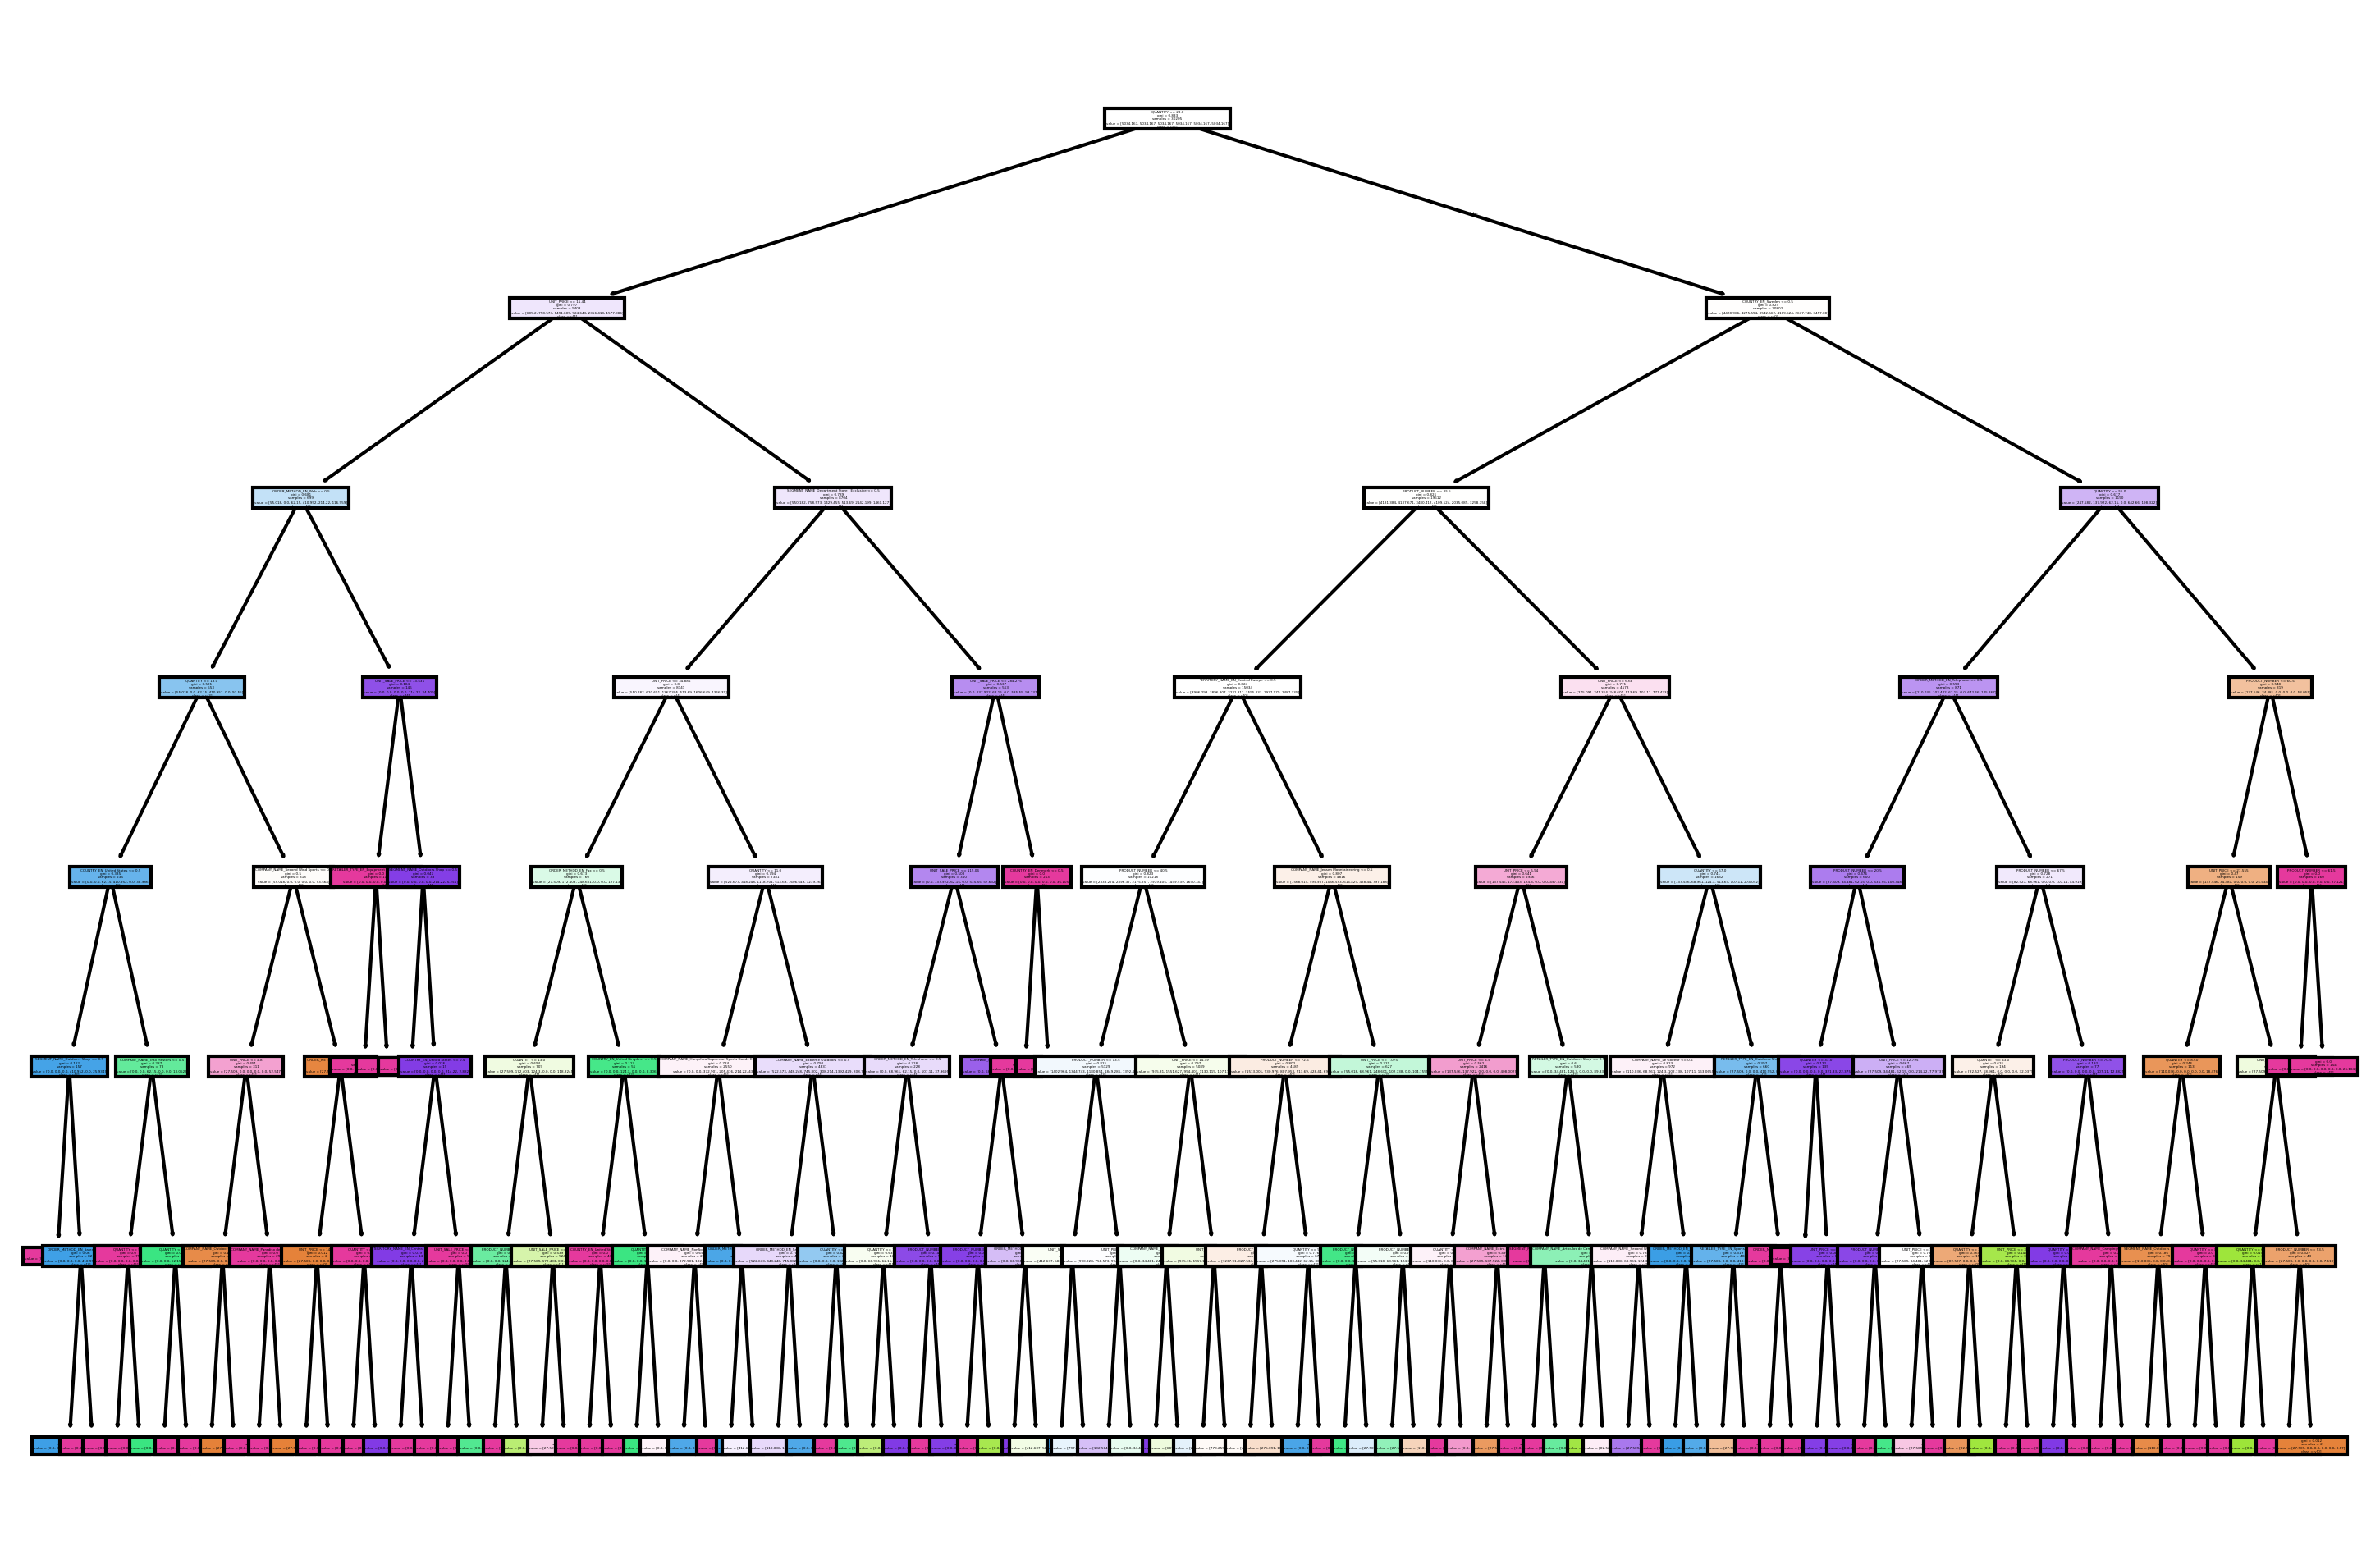

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

dtree = DecisionTreeClassifier(max_depth = 7, class_weight='balanced')
dtree = dtree.fit(X_train, y_train)

plt.figure(figsize=(12, 8), dpi=300)  # Verhoog de DPI en pas de grootte aan
plot_tree(dtree, feature_names=X_encoded.columns, class_names=True, filled=True,)
plt.show()


<h3> kijken hoeveel goed voorspeld zijn

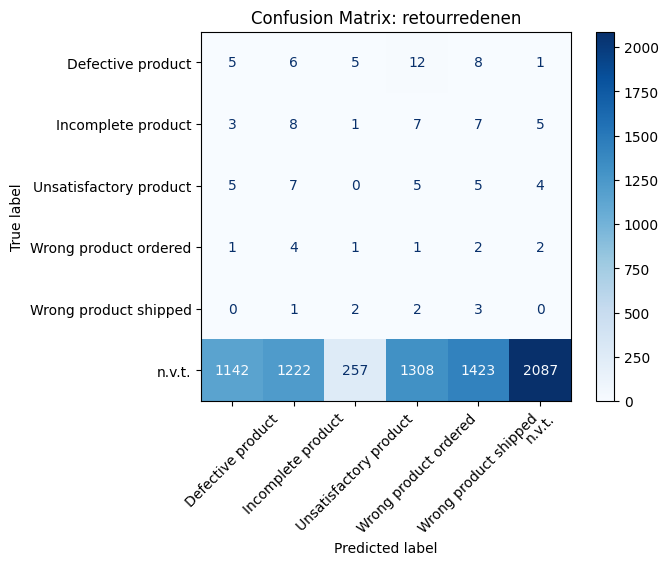

Accuracy van het classificatiemodel: 0.28
                        precision    recall  f1-score   support

     Defective product       0.00      0.14      0.01        37
    Incomplete product       0.01      0.26      0.01        31
Unsatisfactory product       0.00      0.00      0.00        26
 Wrong product ordered       0.00      0.09      0.00        11
 Wrong product shipped       0.00      0.38      0.00         8
                n.v.t.       0.99      0.28      0.44      7439

              accuracy                           0.28      7552
             macro avg       0.17      0.19      0.08      7552
          weighted avg       0.98      0.28      0.43      7552



In [33]:
# Voorspellen
y_pred = dtree.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: retourredenen")
plt.show()

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy van het classificatiemodel: {accuracy:.2f}")

# Extra metrics
print(classification_report(y_test, y_pred, zero_division=0))

<h3> nieuw model trainen

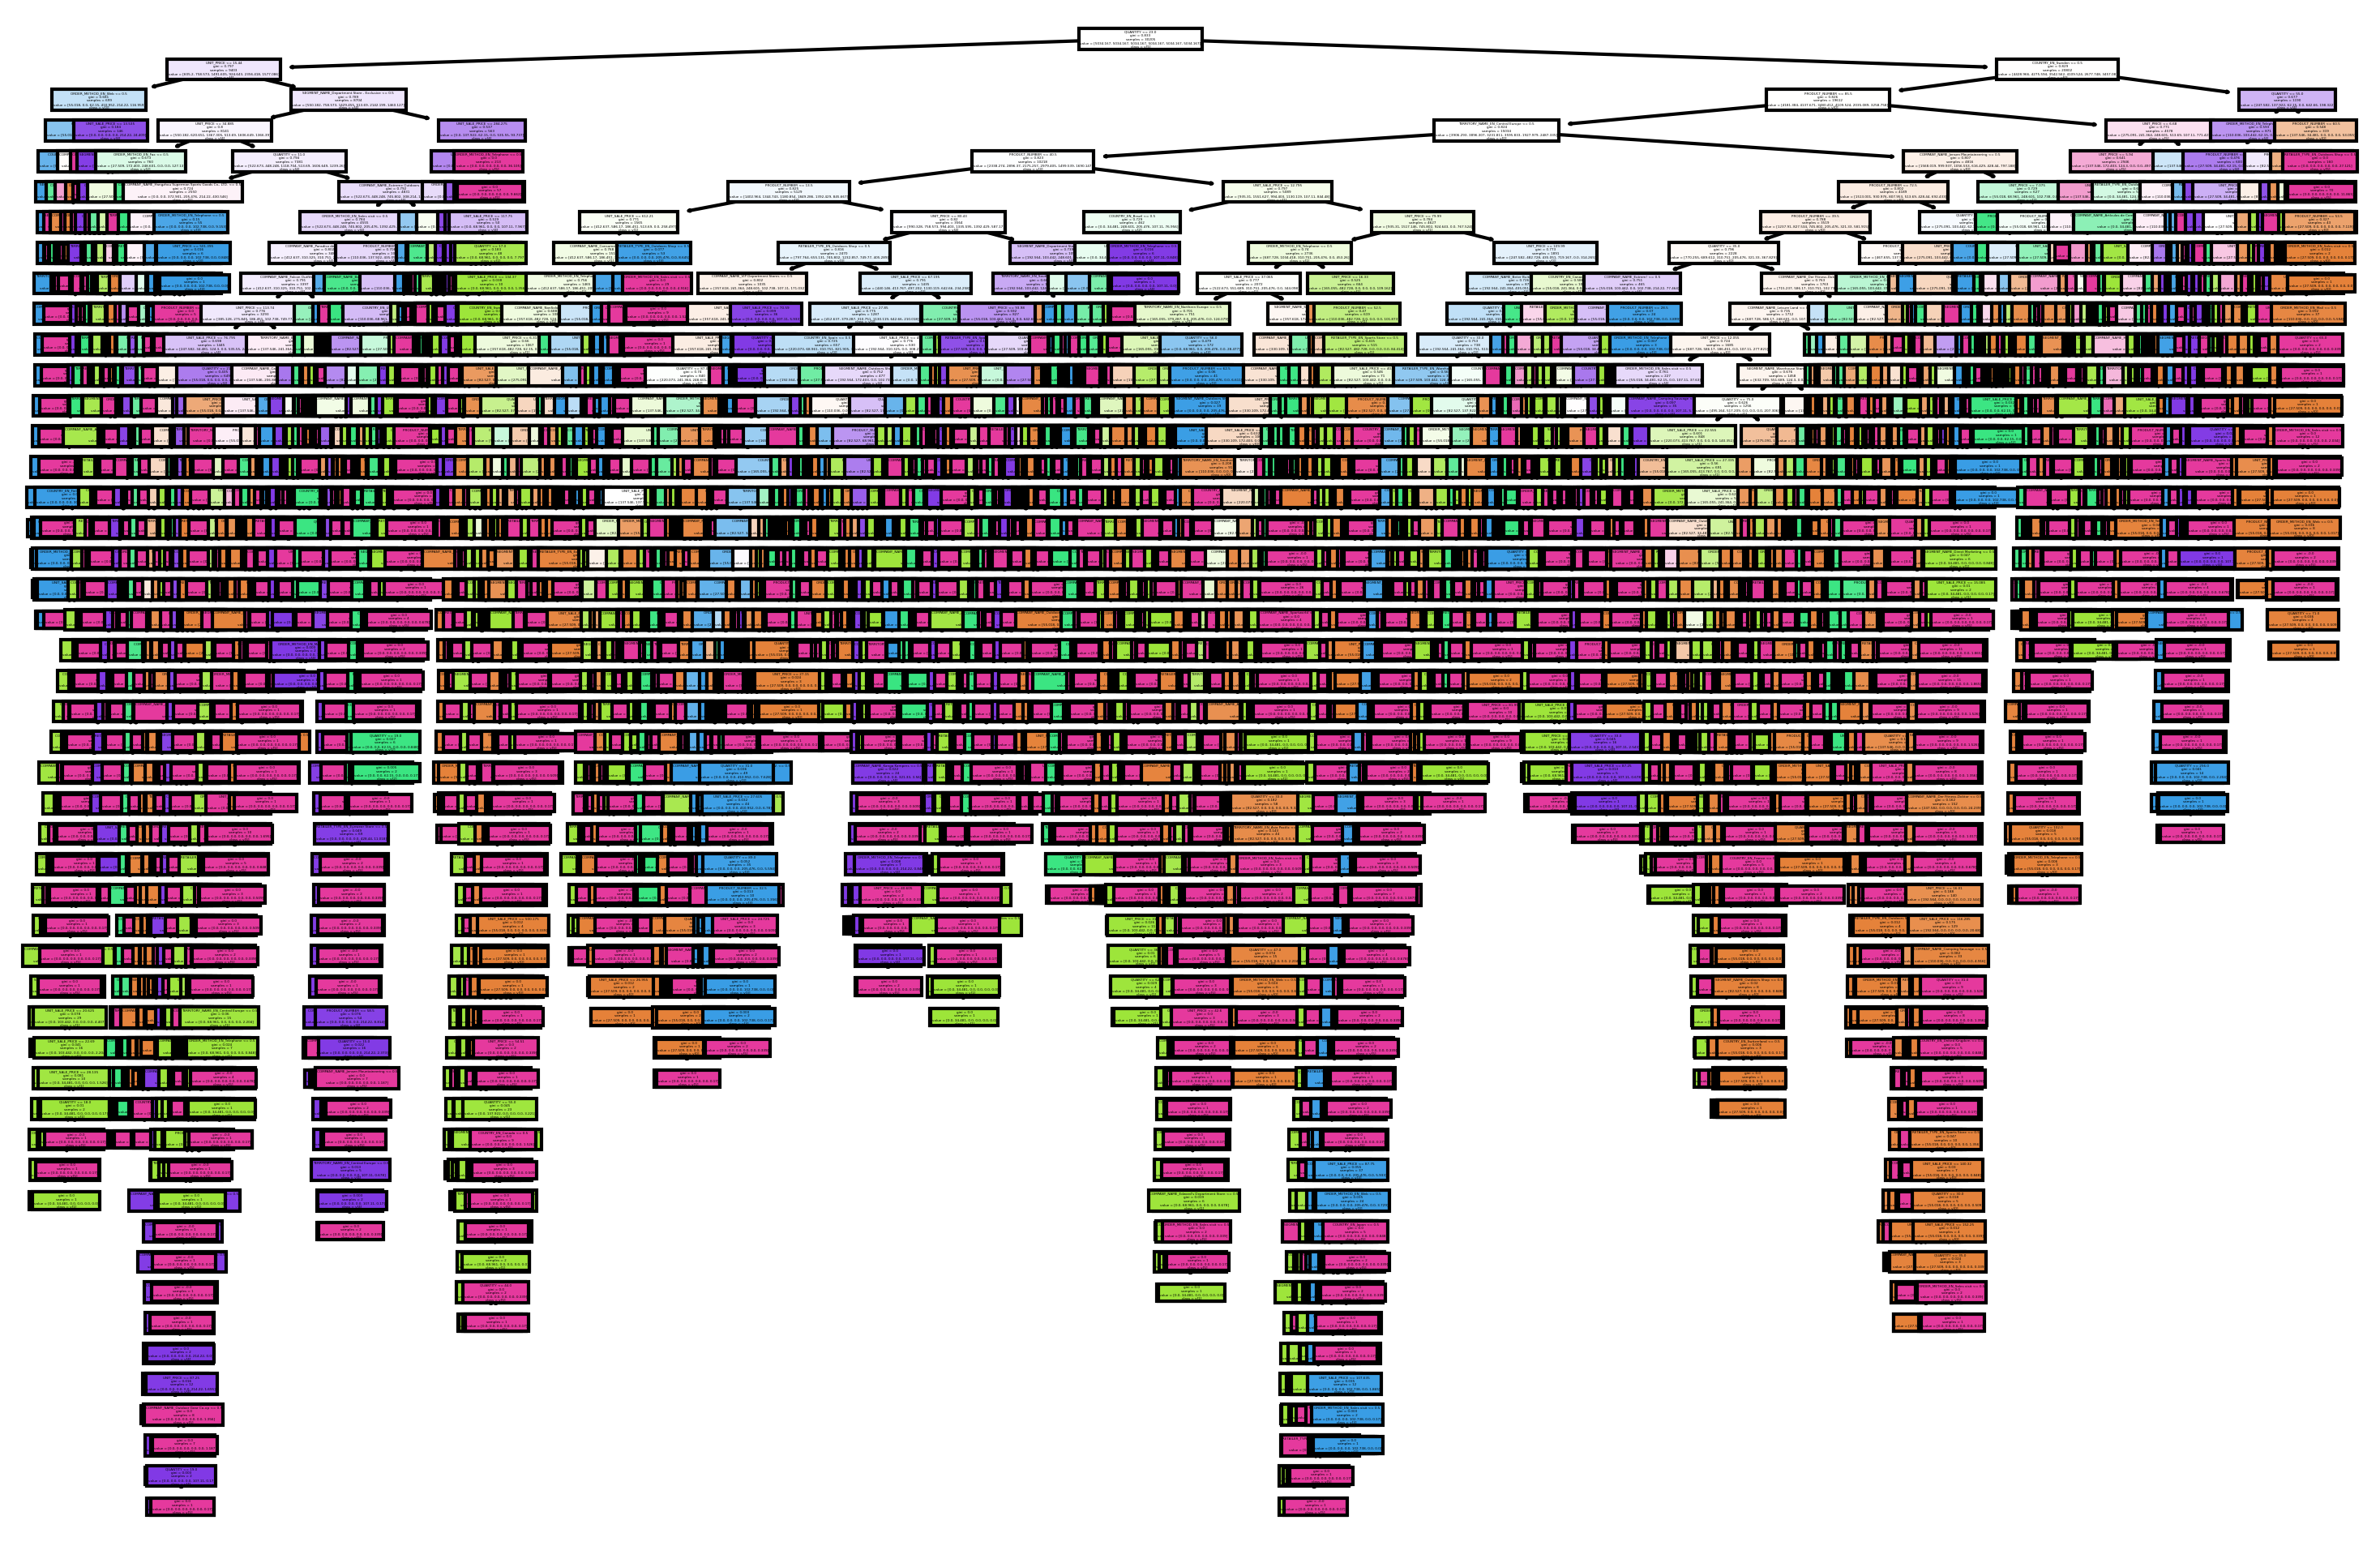

In [34]:
dtree2 = DecisionTreeClassifier( class_weight='balanced')
dtree2 = dtree2.fit(X_train, y_train)

plt.figure(figsize=(12, 8), dpi=300)  # Verhoog de DPI en pas de grootte aan
plot_tree(dtree2, feature_names=X_encoded.columns, class_names=True, filled=True,)
plt.show()


<h3> kijken naar confusion matrix

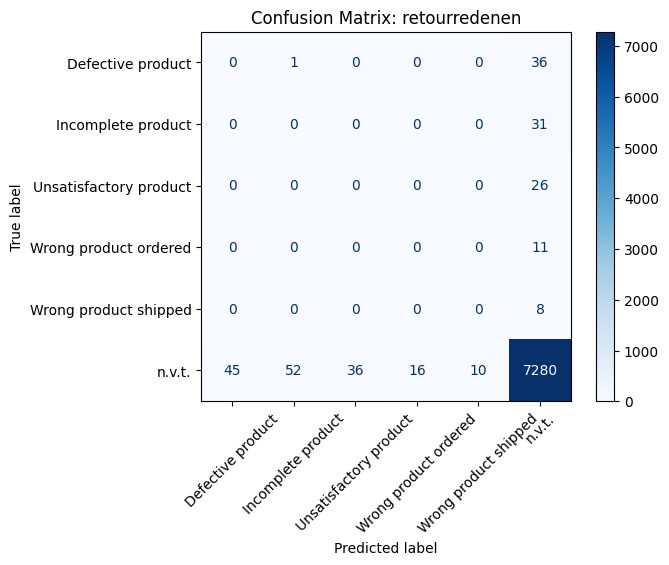

Accuracy van het classificatiemodel: 0.96
                        precision    recall  f1-score   support

     Defective product       0.00      0.00      0.00        37
    Incomplete product       0.00      0.00      0.00        31
Unsatisfactory product       0.00      0.00      0.00        26
 Wrong product ordered       0.00      0.00      0.00        11
 Wrong product shipped       0.00      0.00      0.00         8
                n.v.t.       0.98      0.98      0.98      7439

              accuracy                           0.96      7552
             macro avg       0.16      0.16      0.16      7552
          weighted avg       0.97      0.96      0.97      7552



In [35]:
# Voorspellen
y_pred2 = dtree2.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred2, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: retourredenen")
plt.show()

accuracy = metrics.accuracy_score(y_test, y_pred2)
print(f"Accuracy van het classificatiemodel: {accuracy:.2f}")

# Extra metrics
print(classification_report(y_test, y_pred2, zero_division=0))

<h4> de accuracy is heel hoog hier omdat de ai bijna altijd nvt voorspeld aangezien dit verreweg de meest voorkomende reden is voor retour terwijl het helemaal geen reden ervoor is. ik zal nu alle waarden met nvt droppen

In [36]:
# Verwijder alle rijen waar de retourreden 'n.v.t.' is
df_returns_only = df[df["RETURN_DESCRIPTION_EN"] != "n.v.t."].copy()

# Definieer X en y opnieuw met alleen de gewenste features en doelvariabele
X = df_returns_only[[
    "PRODUCT_NUMBER",
    "QUANTITY",
    "UNIT_PRICE",
    "UNIT_SALE_PRICE",
    "ORDER_METHOD_EN",
    "COMPANY_NAME",
    "SEGMENT_NAME",
    "RETAILER_TYPE_EN",
    "COUNTRY_EN",
    "TERRITORY_NAME_EN"
]]

X_encoded = pd.get_dummies(X, drop_first=True)  


y = df_returns_only["RETURN_DESCRIPTION_EN"]


print(f"X shape: {X_encoded.shape}")
print(f"y shape: {y.shape}")
print(y.value_counts())


X shape: (619, 136)
y shape: (619,)
RETURN_DESCRIPTION_EN
Defective product         220
Incomplete product        177
Unsatisfactory product    107
Wrong product ordered      60
Wrong product shipped      55
Name: count, dtype: int64


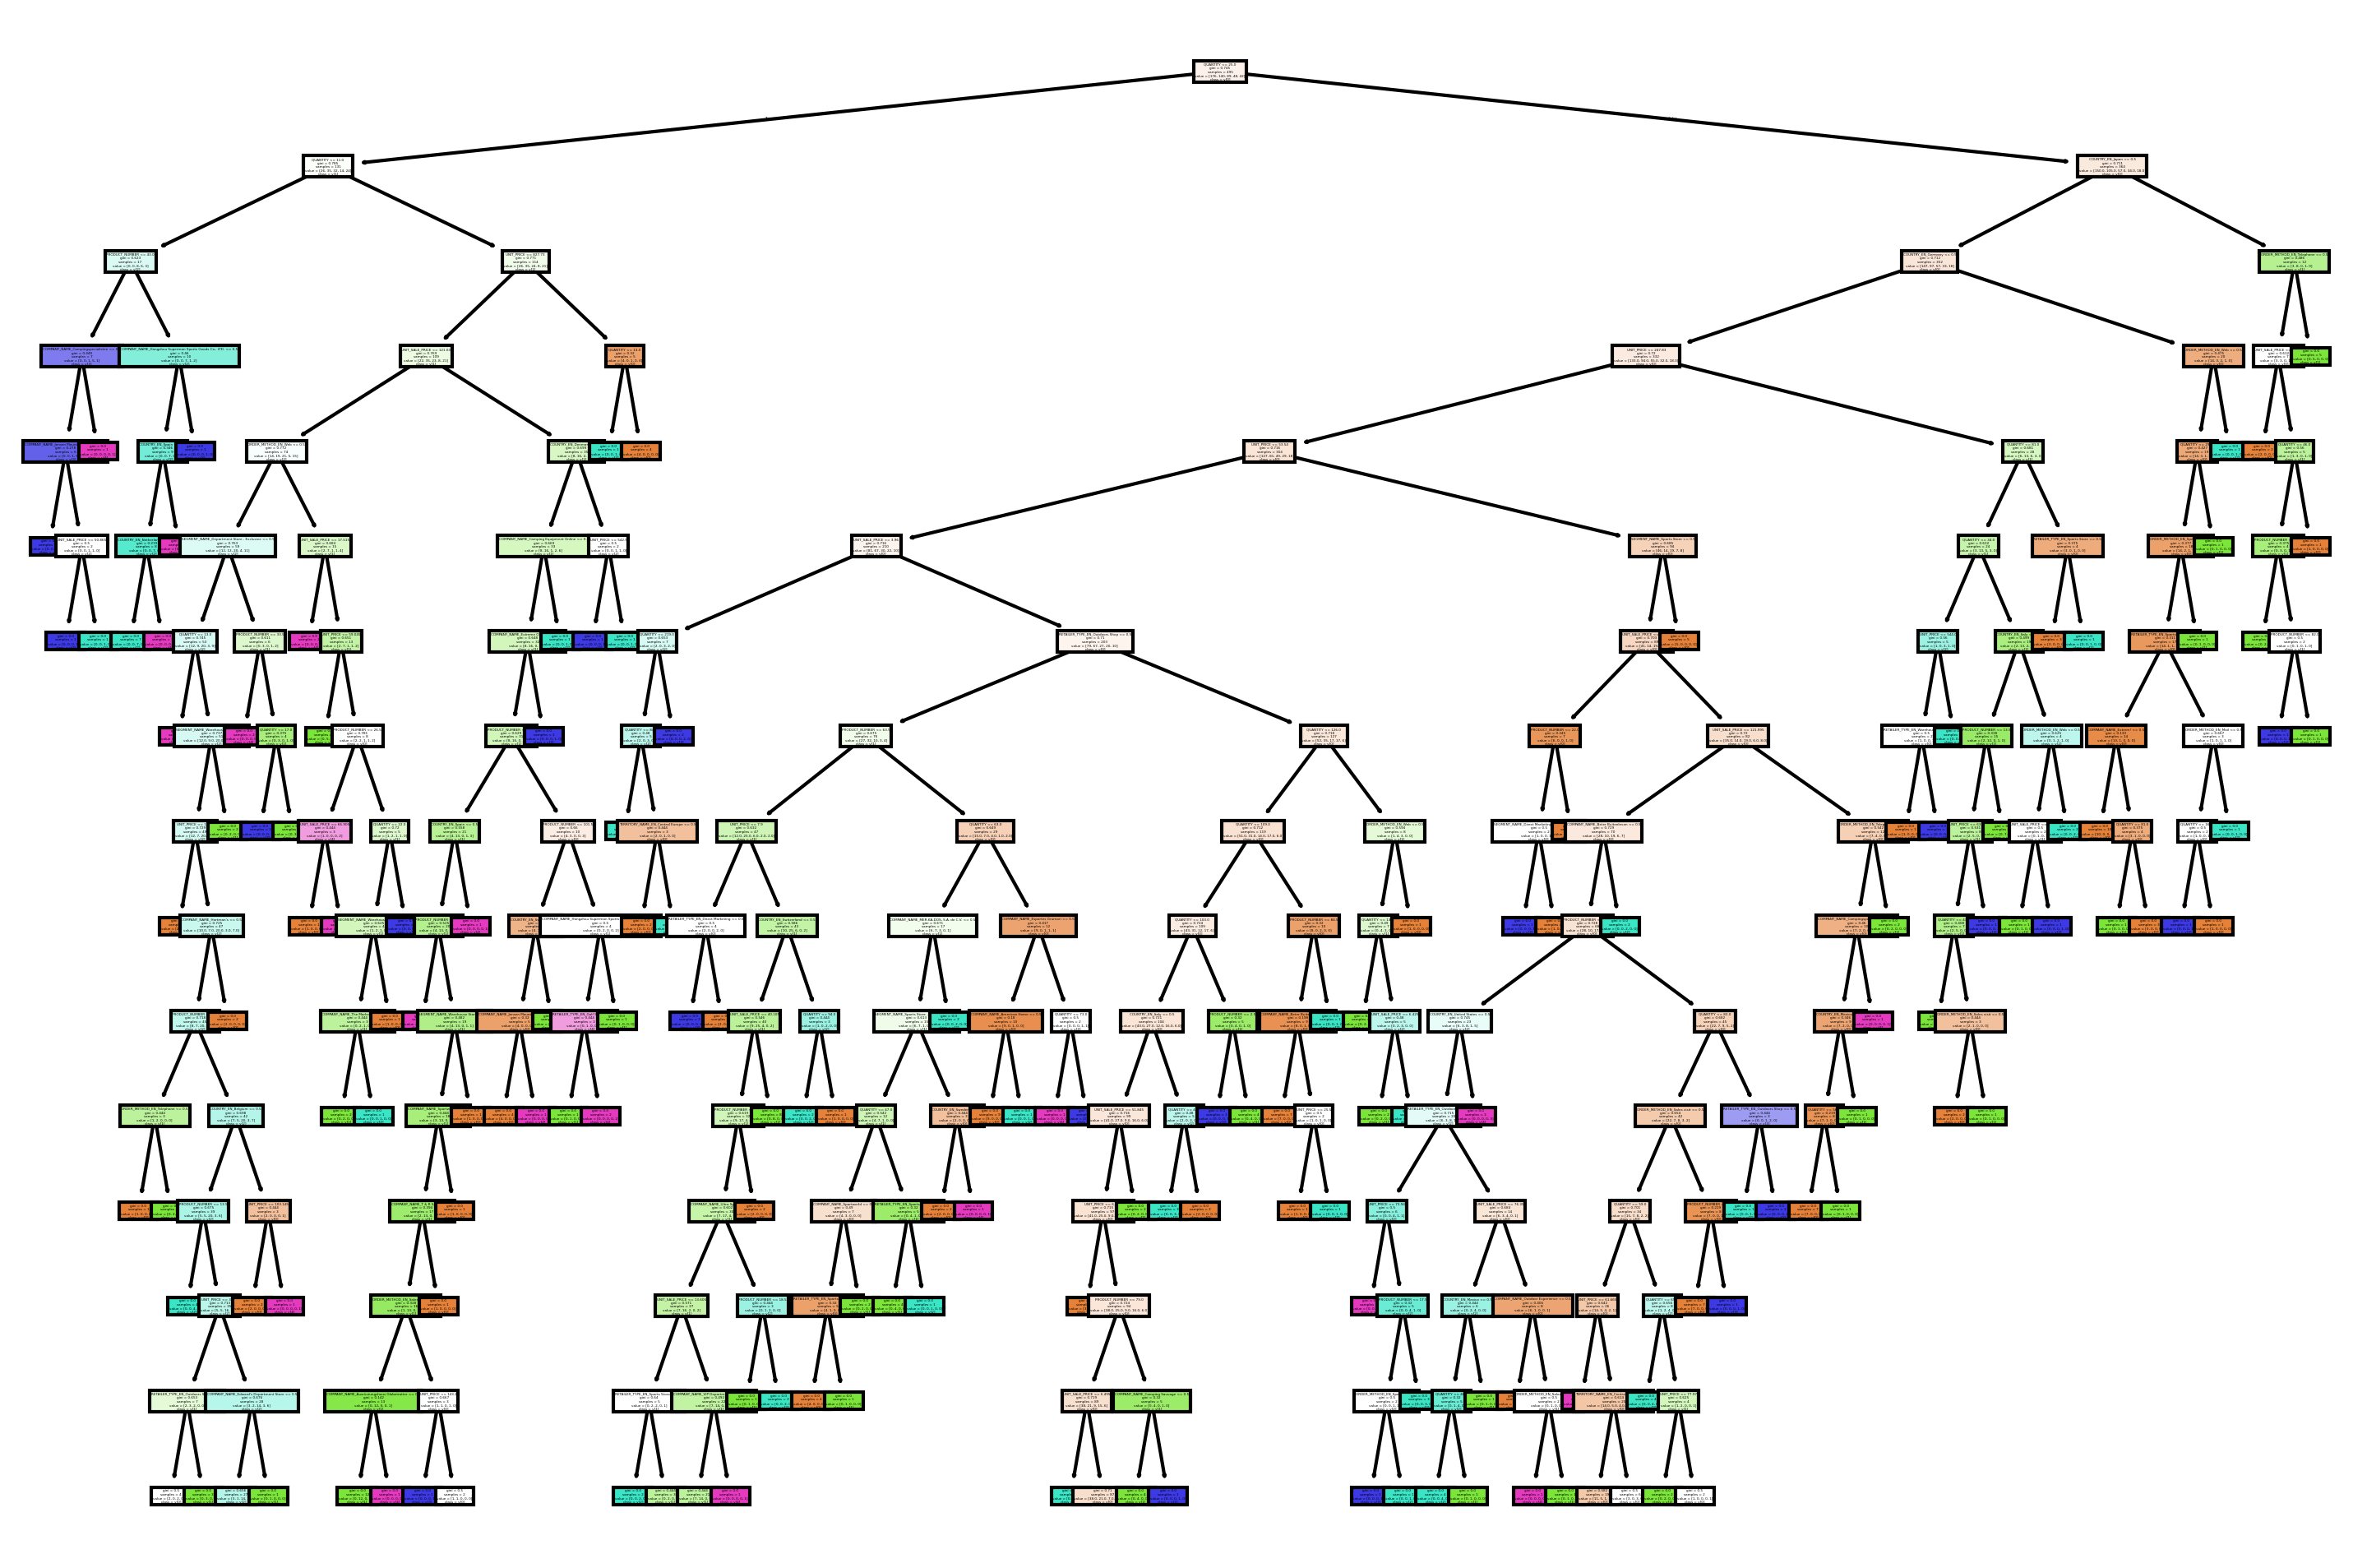

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

dtree = DecisionTreeClassifier(max_depth = 15)
dtree = dtree.fit(X_train, y_train)

plt.figure(figsize=(12, 8), dpi=300)  # Verhoog de DPI en pas de grootte aan
plot_tree(dtree, feature_names=X_encoded.columns, class_names=True, filled=True,)
plt.show()


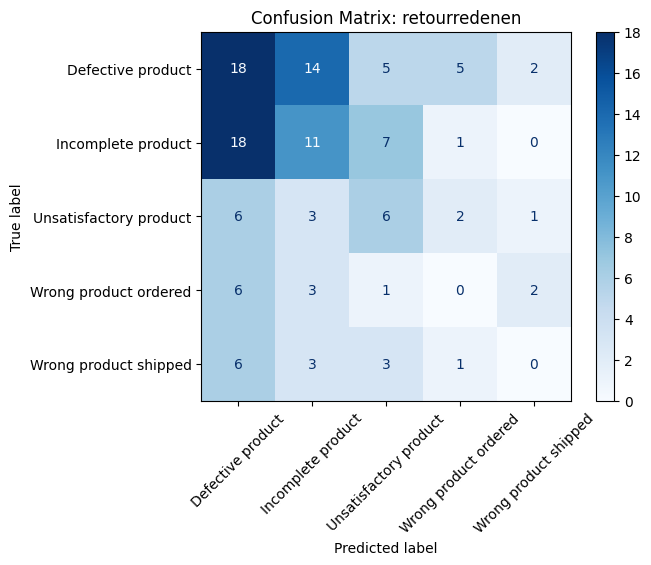

Accuracy van het classificatiemodel: 0.28
                        precision    recall  f1-score   support

     Defective product       0.33      0.41      0.37        44
    Incomplete product       0.32      0.30      0.31        37
Unsatisfactory product       0.27      0.33      0.30        18
 Wrong product ordered       0.00      0.00      0.00        12
 Wrong product shipped       0.00      0.00      0.00        13

              accuracy                           0.28       124
             macro avg       0.19      0.21      0.20       124
          weighted avg       0.25      0.28      0.27       124



In [38]:
# Voorspellen
y_pred = dtree.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: retourredenen")
plt.show()

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy van het classificatiemodel: {accuracy:.2f}")

# Extra metrics
print(classification_report(y_test, y_pred, zero_division=0))